In [35]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [11]:
sqliteConnection = sqlite3.connect("../db.sqlite3")
cursor = sqliteConnection.cursor()
print("Connected to SQLite")

query = """
    SELECT 
        ro.id AS order_id,
        ro.datetime AS order_datetime,
        roi.id AS item_id,
        roi.quantity,
        rp.id AS product_id,
        rp.price,
        rp.name
    FROM 
        restaurant_order AS ro
    INNER JOIN 
        restaurant_orderitem AS roi ON ro.id = roi.order_id
    INNER JOIN 
        restaurant_product AS rp ON roi.product_id = rp.id
"""
cursor.execute(query)
records = cursor.fetchall()

cursor.close()
sqliteConnection.close()

df = pd.DataFrame(records, columns=["order_id", "order_datetime", "item_id", "quantity", "product_id", "price", "name"])
df = df.drop(columns=["order_id", "product_id", "item_id"])
df


Connected to SQLite


,order_datetime,quantity,price,name
0,2019-08-03 20:25:00,2,0.80,Plain Papadum
1,2019-08-03 20:25:00,1,12.95,King Prawn Balti
2,2019-08-03 20:25:00,1,2.95,Garlic Naan
3,2019-08-03 20:25:00,1,3.95,Mushroom Rice
4,2019-08-03 20:25:00,1,8.95,Paneer Tikka Masala
...,...,...,...,...
74813,2016-05-18 18:53:00,2,17.95,House Red wine 75cl
74814,2016-05-14 19:28:00,2,17.95,House Red wine 75cl
74815,2016-05-10 13:18:00,2,17.95,House Red wine 75cl
74816,2016-04-07 19:04:00,1,17.95,House white wine 75cl


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

Text(0.5, 1.0, 'Top 10 Most Popular Products by Quantity')

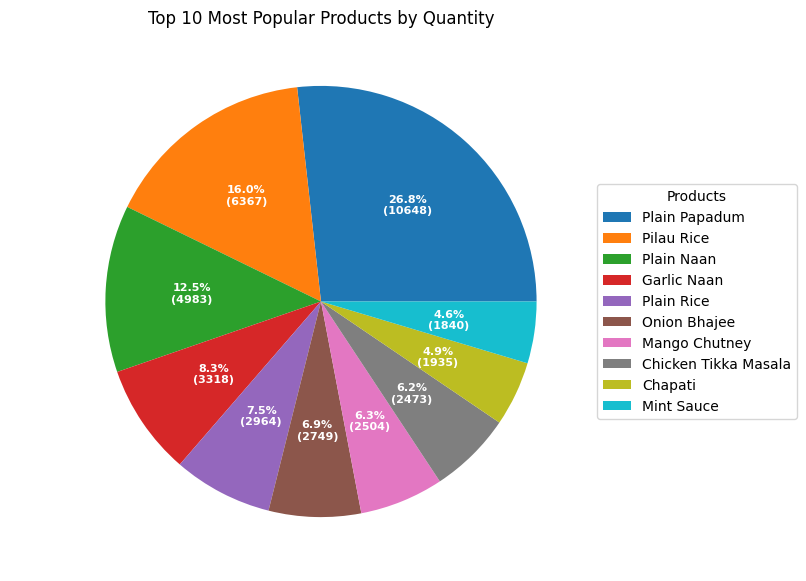

In [36]:
product_popularity = df.groupby("name")["quantity"].sum().reset_index()

top_products = product_popularity.nlargest(10, "quantity")

top_products["percentage"] = (top_products["quantity"] / top_products["quantity"].sum()) * 100

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(
    top_products["percentage"], 
    labels=top_products["name"], 
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*top_products['quantity'].sum())})", 
    textprops=dict(color="w")
)

ax.legend(wedges, top_products["name"],
          title="Products",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Top 10 Most Popular Products by Quantity")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

Text(0.5, 1.0, 'Top 10 Most Revenue Generating Products')

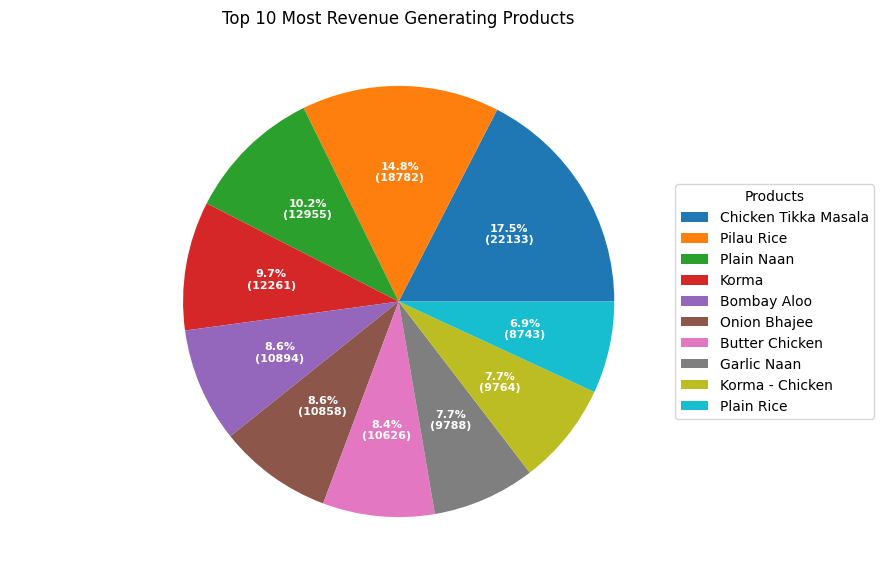

In [37]:
df["item_price"] = df["price"] * df["quantity"]

product_revenue = df.groupby("name")["item_price"].sum().reset_index()

top_products_revenue = product_revenue.nlargest(10, "item_price")
total_revenue = top_products_revenue["item_price"].sum()
top_products_revenue["percentage"] = (top_products_revenue["item_price"] / total_revenue) * 100


fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(
    top_products_revenue["percentage"], 
    labels=top_products_revenue["item_price"], 
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*total_revenue):d})", 
    textprops=dict(color="w")
)

ax.legend(wedges, top_products_revenue["name"],
          title="Products",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Top 10 Most Revenue Generating Products")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

([<matplotlib.axis.XTick at 0x254dbe04d90>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

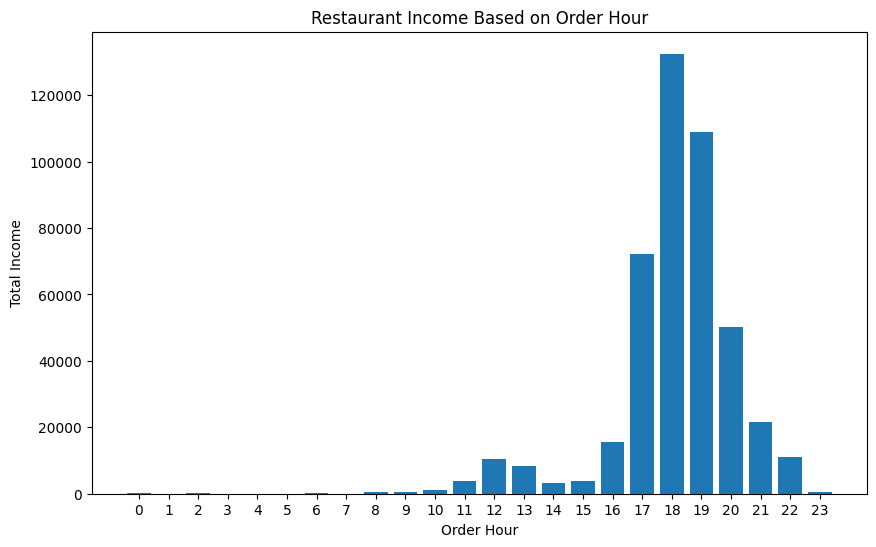

In [44]:
df["order_datetime"] = pd.to_datetime(df["order_datetime"])

df["order_hour"] = df["order_datetime"].dt.hour

hourly_income = df.groupby("order_hour")["item_price"].sum()

plt.figure(figsize=(10, 6))
plt.bar(hourly_income.index, hourly_income.values)
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Restaurant Income Based on Order Hour")
plt.xticks(range(24))

|# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

Text(0.5, 1.0, 'Restaurant Income Based on Day of the Week')

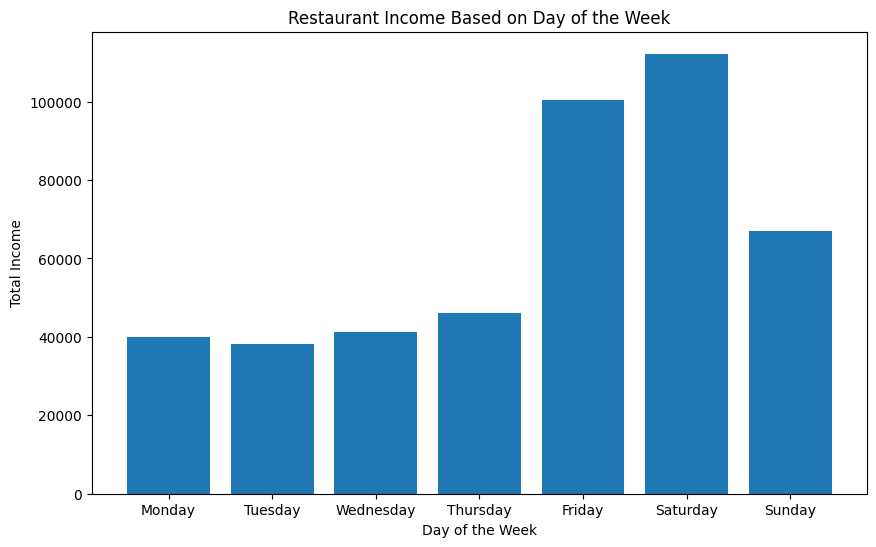

In [51]:
df["order_day_of_week"] = df["order_datetime"].dt.dayofweek

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

daily_income = df.groupby("order_day_of_week")["item_price"].sum()

daily_income = daily_income.reindex(range(7), fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(day_names, daily_income)
plt.xlabel("Day of the Week")
plt.ylabel("Total Income")
plt.title("Restaurant Income Based on Day of the Week")